In [4]:
#Loading packages
import numpy as np
import pandas as pd
from pandas import datetime

#Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#statistics
from statsmodels.distributions.empirical_distribution import ECDF

#time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
import warnings
warnings.filterwarnings("ignore")

**Loading dataset and Data Cleaning**

In [6]:
from google.colab import files
data_to_load = files.upload()

Saving store.csv to store.csv


In [7]:
import io
df = pd.read_csv(io.BytesIO(data_to_load['store.csv']),parse_dates=True,low_memory=False,index_col='Date')
#store=pd.read_csv(io.BytesIO(data_to_load['store.csv']),low_memory=False)
df.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [8]:
data_to_load = files.upload()

Saving stores.csv to stores.csv


In [9]:
store=pd.read_csv(io.BytesIO(data_to_load['stores.csv']),low_memory=False)

In [10]:
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


In [12]:
df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


## **Description**

There are a total 1017209 entries and 8 columns .
There are 7 int datatype column and 2 object datatype column.

**Store -** store number

**DayofWeek-** Day of the week 

**Date-** date on which purchase was done

**Sales-** Sales on that particular date

**Customers-**Number of customers on that particular date

**Open-** indicator for whether that day the particular store was open or closed 0-closed 1-open 

**Promo-**It indicates whether store is running promo or not

**SchoolHoliday-** Whether it was affected by school holiday or not

In [13]:
#data extraction
df['year']=df.index.year
df['month']=df.index.month
df['day']=df.index.day
df['weekofyear']=df.index.weekofyear

In [14]:
#creating new column
df['SalesPerCustomer']=df['Sales']/df['Customers']
df['SalesPerCustomer'].describe()


count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalesPerCustomer, dtype: float64

Analysing Data

In [15]:
#checking the number of closed stores
df.loc[(df.Open==0)&(df.Sales==0)].shape

(172817, 13)

*There are a total 172817 stores which are closed and sales on that particular date is 0*

In [16]:
#checking if there are stores which were open with 0 sales
df.loc[(df.Open!=0)& (df.Sales==0)].shape


(54, 13)

There are a total of 54 data with stores opened still with zero sales

In [17]:
#selecting only those stores which were open. Removing values with stores which were closed
df=df[(df['Open']!=0) & (df['Sales']!=0)]
print("Total: ",df.shape)


Total:  (844338, 13)


In [18]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


**Data Description**

Store: a unique Store ID

StoreType: different store types: a, b, c or d

Assortment: describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance: Distance of the nearest competition store in meters

CompetitionOpenSince[Month/Year]: The the year or month when the nearest competitor store opened

Promo2: It is a promotion column with boolean values : 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2

PromoInterval: Month when the Promo2 started


**Checking the missing or null values**

In [19]:
store.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [20]:
#CompetitionDistance has 3 missing values.So we will fill it with median values
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(),inplace=True)

In [21]:
ab=store[store['Promo2']==0]
ab.shape

(544, 10)

In [22]:
ab.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    148
CompetitionOpenSinceYear     148
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

We can see that where the promo2 is 0, that is wherever promo2 is 0 the value Promo2SinceWeek Promor2SinceYear and PromoInterval are missing. Thus we will fill those missing values with zero

In [23]:
store.fillna(0, inplace = True)

Next we will merge both the datasets

In [24]:
new_df=pd.merge(df,store,how='inner',on='Store')
new_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day,weekofyear,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,30,31,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,29,31,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,28,31,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,27,31,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [25]:
new_df.shape

(844338, 22)

**Exploratory Data Analysis**

In [26]:
new_df.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'year', 'month', 'day', 'weekofyear',
       'SalesPerCustomer', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [27]:
#lets analyze the sales with respect to different stores

In [28]:
new_df.head(4)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day,weekofyear,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,30,31,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,29,31,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,28,31,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [29]:
new_df.StoreType.value_counts()

a    457042
d    258768
c    112968
b     15560
Name: StoreType, dtype: int64

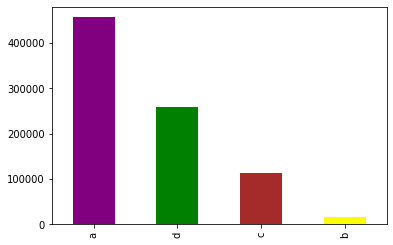

In [30]:
new_df.StoreType.value_counts().plot(kind='bar',color=['purple','green','brown','yellow'])

we can infer from the above plot that the maximum number of customers are of Store Type a followed by store Type d and the least number is of store type b

**Now lets check the sales of different stores**

In [31]:
new_df.groupby('StoreType').Sales.mean()

StoreType
a     6925.697986
b    10233.380141
c     6933.126425
d     6822.300064
Name: Sales, dtype: float64

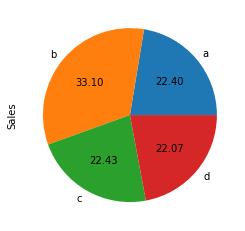

In [32]:
new_df.groupby('StoreType').Sales.mean().plot(kind='pie', autopct='%.2f')

From the above pie chart we can infer that the maximum sales was in Store Type b around 33% of the total sales and the least was in store type d i.e. 22.07%. While sales in store type a and c is almost same i.e. 22.40 and 22.43

**NOW LETS CHECK THE YEARLY AND MONTHLY SALES**

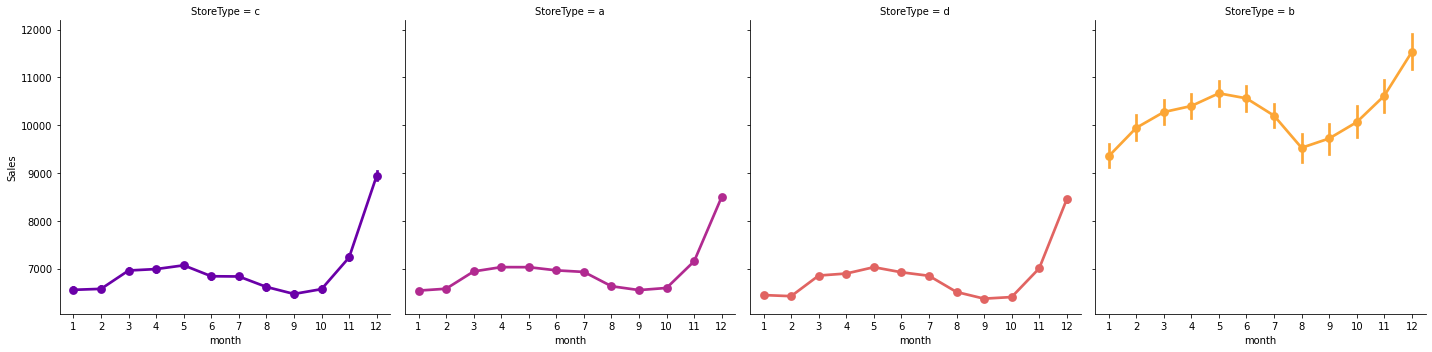

In [33]:
sns.factorplot(data = new_df, x = 'month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               color = ['brown','purple','yellow','teal']) 

As we can see sales of **store type B** is maximum and seasonality in all the store is almost similar that is towards the end in december the sales is maximum for all the store types. While there is a decrease in sales during August and September.

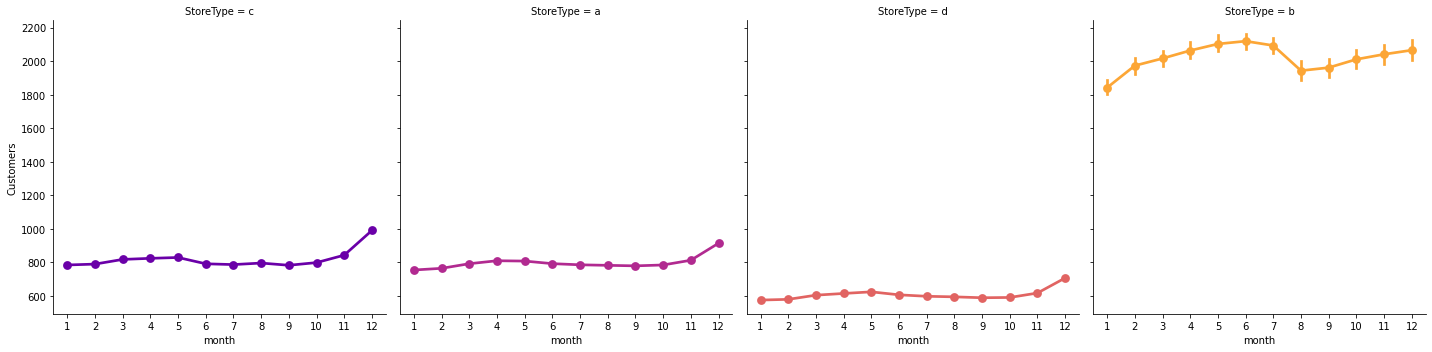

In [34]:
sns.factorplot(data = new_df, x = 'month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               color = ['black','yellow','brown','orange']) 

More number of customers have come in store type b with .And the number of customers is almost constant for all the stpre types. 

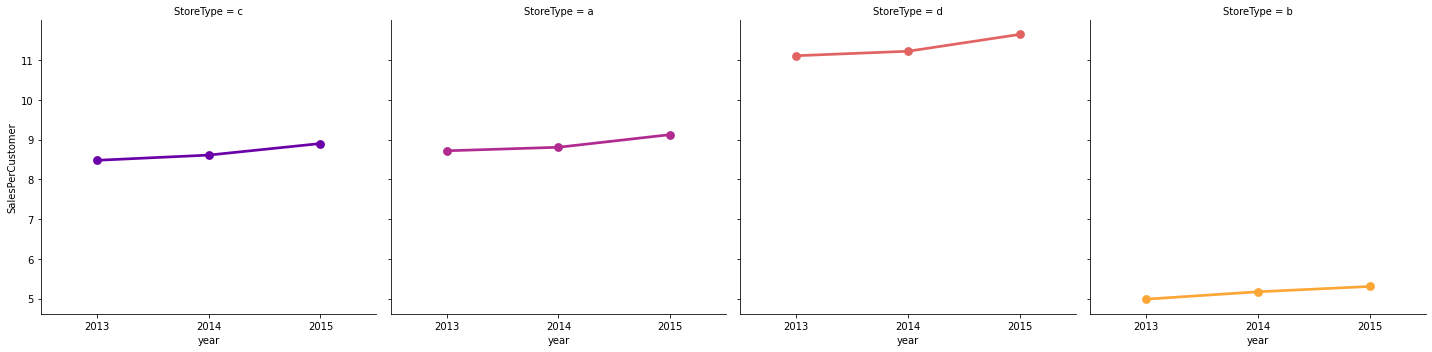

In [35]:
sns.factorplot(data = new_df, x = 'year', y = "SalesPerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               color = ['black','yellow','brown','orange']) 

There's an increasing trend in all the store types.Sales per customer is very low in store type b and highest in d

-----------------------------------------------------------------------

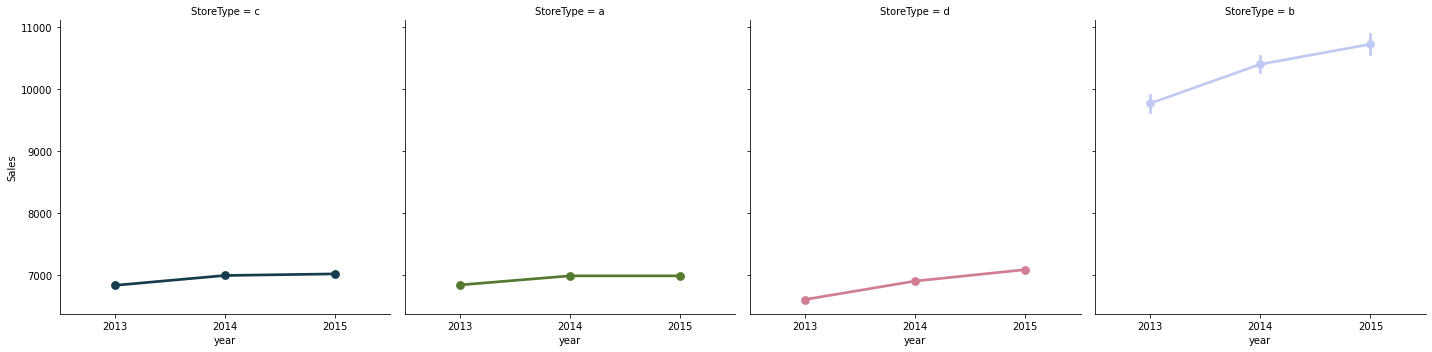

In [36]:
sns.factorplot(data = new_df, x = 'year', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'cubehelix',
               hue = 'StoreType',
               color = ['black','yellow','brown','orange']) 

While sales is high in store type b as there were more number of customers

**Now lets check relation of sales wrt week of day when promotion is applied**

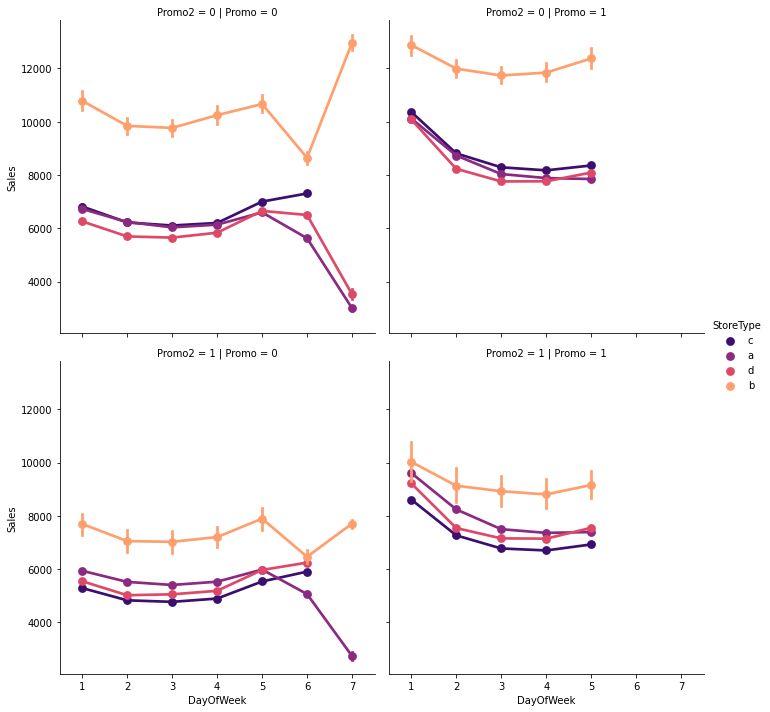

In [37]:
sns.factorplot(data = new_df, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'StoreType',
               palette = 'magma') 

We can see that 
> Whenever Promo1 promotion is applied the sale is higher towards the starting

> When no promotion is applied then there is a decrease in sales of all store types

>When Promo2 is applied and Promo is not applied; Sales of store type a decreased towards the end. while store type b remained high.

>When both promotion are applied then the sales of all the store type is constant.With little decrease.

In [38]:
new_df.groupby('SchoolHoliday').Sales.mean()

SchoolHoliday
0    6897.207830
1    7200.710282
Name: Sales, dtype: float64

Sales on a school holiday is more

In [39]:
new_df.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'year', 'month', 'day', 'weekofyear',
       'SalesPerCustomer', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

Text(0, 0.5, 'Sales')

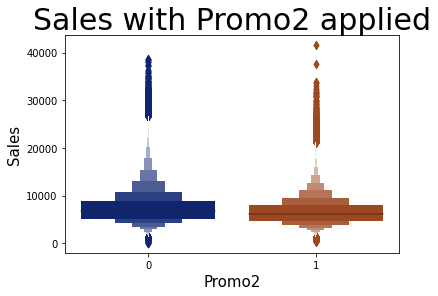

In [40]:
sns.boxenplot(new_df['Promo2'], new_df['Sales'], palette = 'dark')
plt.title('Sales with Promo2 applied', fontsize = 30)
plt.xlabel('Promo2', fontsize = 15)
plt.ylabel('Sales', fontsize = 15)


There are few extreme values whene promotion Promo2 was applied there were highes sales when promotion was applied. 

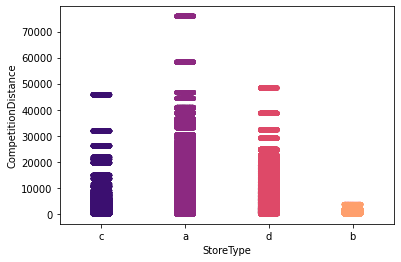

In [41]:
sns.stripplot(new_df['StoreType'], new_df['CompetitionDistance'], palette = 'magma')

The lowest competition distance for store type b is lowest and for store type a is highest

In [42]:
SalesWDis=new_df.groupby(['StoreType']).agg({'SalesPerCustomer' : 'mean', 'CompetitionDistance' : 'mean'})
SalesWDis

,SalesPerCustomer,CompetitionDistance
StoreType,,
a,8.846296,5222.902709
b,5.133427,1072.572622
c,8.626227,3514.147192
d,11.277862,6959.587971


We can notice that as the distnace of competitive store is more sales per customer is also more.And wherever the distance of competition store is less for example storetype b the sales per customer is also low.

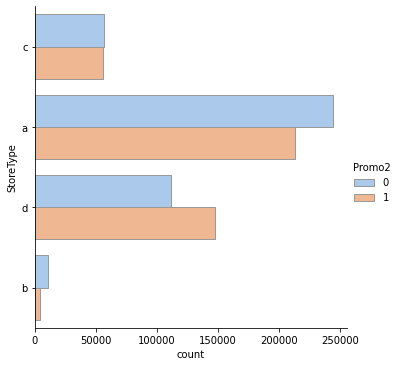

In [43]:
sns.catplot(y="StoreType", hue="Promo2", kind="count",
            palette="pastel", edgecolor=".6",
            data=new_df);

**Now lets check the correlation between all the constraints**

Text(0.5, 1.0, 'Heatmap of Correlation Matrix')

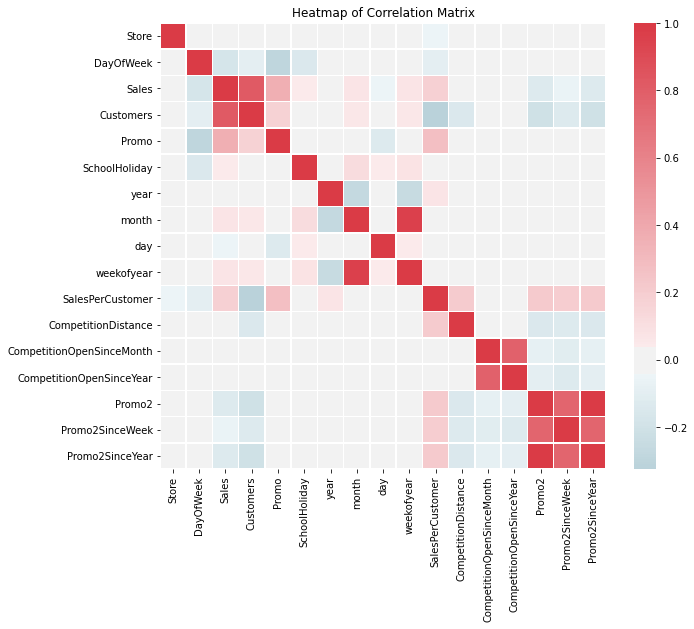

In [44]:
corr_matrix=new_df.drop('Open', axis = 1).corr()

# Heatmap
plt.figure(figsize = (10,10))
cmap = sns.diverging_palette(220,10,as_cmap = True)

#Deep dive into diverging_pattern
sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns.values,
           yticklabels=corr_matrix.columns.values, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .82})
plt.title('Heatmap of Correlation Matrix')

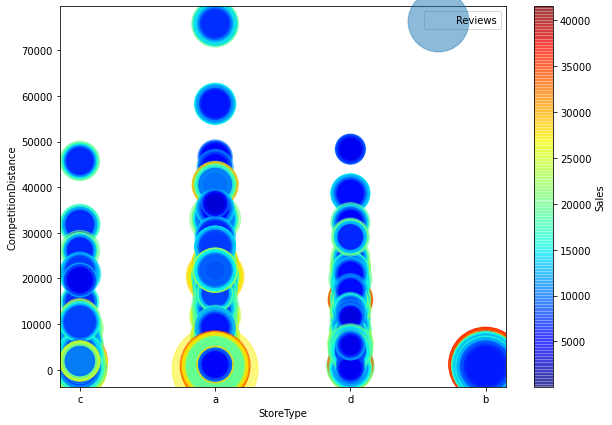

In [45]:
new_df.plot(kind="scatter", x="StoreType", y="CompetitionDistance", alpha=0.5,
    s=new_df["Customers"], label="Reviews", figsize=(10,7),
    c="Sales", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()


Here we can see that Highest sales is of store type b and the competition distance is low.

**Time Series Analysis**

**Time Series Feature:**
1. Data is not dependent 
2. In observations; ordering matters
3. Ordering is important by changing , the order will change the data structure

**OBJECTIVE**
Objective is to learn to forecast, forecasting depends on :
1. how well the contributing factors are understood.
2. How much data is available.

If there are any missing data, Time series does not admit missing data bcz it will remove historic patterns relevant to forecasting and creates mismatching in forecasting model.



We will analyze the seasonality and trend for different store types.
For that we will select different store numbers for different store types a ,b,c and d.

In [46]:
new_df.loc[new_df['StoreType']=='a'].head(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day,weekofyear,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
781,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
782,2,4,5567,601,1,1,0,1,2015,7,30,31,9.262895,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [47]:
new_df.loc[new_df['StoreType']=='b'].head(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day,weekofyear,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
63445,85,5,7791,971,1,1,0,1,2015,7,31,31,8.023687,b,a,1870.0,10.0,2011.0,0,0.0,0.0,0
63446,85,4,7187,1000,1,1,0,1,2015,7,30,31,7.187000,b,a,1870.0,10.0,2011.0,0,0.0,0.0,0


In [48]:
new_df.loc[new_df['StoreType']=='c'].head(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day,weekofyear,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,30,31,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In [49]:
new_df.loc[new_df['StoreType']=='d'].head(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day,weekofyear,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
9388,13,5,8821,568,1,1,0,0,2015,7,31,31,15.529930,d,a,310.0,0.0,0.0,1,45.0,2009.0,"Feb,May,Aug,Nov"
9389,13,4,7648,474,1,1,0,0,2015,7,30,31,16.135021,d,a,310.0,0.0,0.0,1,45.0,2009.0,"Feb,May,Aug,Nov"


In [50]:
new_df.loc[new_df['Store']==2].head(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day,weekofyear,SalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
781,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
782,2,4,5567,601,1,1,0,1,2015,7,30,31,9.262895,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


From the above we can note that:-

>Store Type a: Store number 2 

>Store type b: Store number 85

>Store type c: store number 1

>Store type d: Store number 13

we will convert sales to float datatype

In [51]:
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day,weekofyear,SalesPerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [52]:
df['Sales']=df['Sales']*1.0

In [53]:
sales_a = df[df.Store == 2]['Sales']
sales_b = df[df.Store == 85]['Sales'].sort_index(ascending = True) 
sales_c = df[df.Store == 1]['Sales']
sales_d = df[df.Store == 13]['Sales']

Now lets resample data on weekly basis and check for trend and seasonality for the four store types

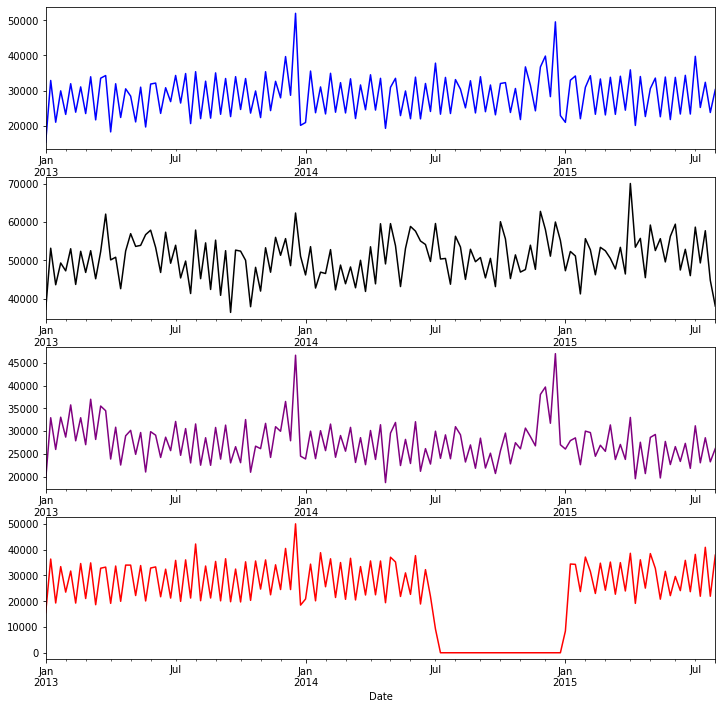

In [54]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 12))
sales_a.resample('W').sum().plot(color ='blue', ax = ax1)
sales_b.resample('W').sum().plot(color ='k', ax = ax2)
sales_c.resample('W').sum().plot(color = 'purple', ax = ax3)
sales_d.resample('W').sum().plot(color = 'red', ax = ax4)

Sales of **store type a** and **Store type c** are increasing in the month of december during the holidays.

Sales of **Store type b** is increasing sometime in month of april

There's a sudden downfall in sales of **store type d** in the year 2014 jul to jan 2015.

**YEARLY TREND**

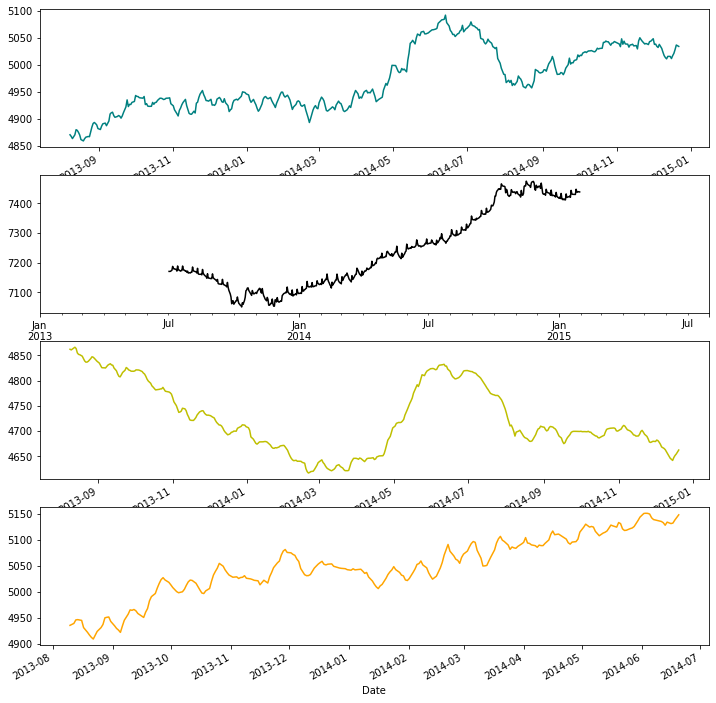

In [55]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
a_de = seasonal_decompose(sales_a, model = 'additive', freq = 365)
a_de.trend.plot(color = 'teal', ax = ax1)

b_de = seasonal_decompose(sales_b, model = 'additive', freq = 365)
b_de.trend.plot(color = 'k', ax = ax2)

c_de = seasonal_decompose(sales_c, model = 'additive', freq = 365)
c_de.trend.plot(color = 'y', ax = ax3)

d_de = seasonal_decompose(sales_d, model = 'additive', freq = 365)
d_de.trend.plot(color = 'orange', ax = ax4)

**We can see that :-**

>for **Store type a** ,**Store type b** and **Store type d** trend of sales is always increasing in 2014' April and then again the retail sales has decreased.

>For **Store type c** there is decrease in sales and then a sudden increase 

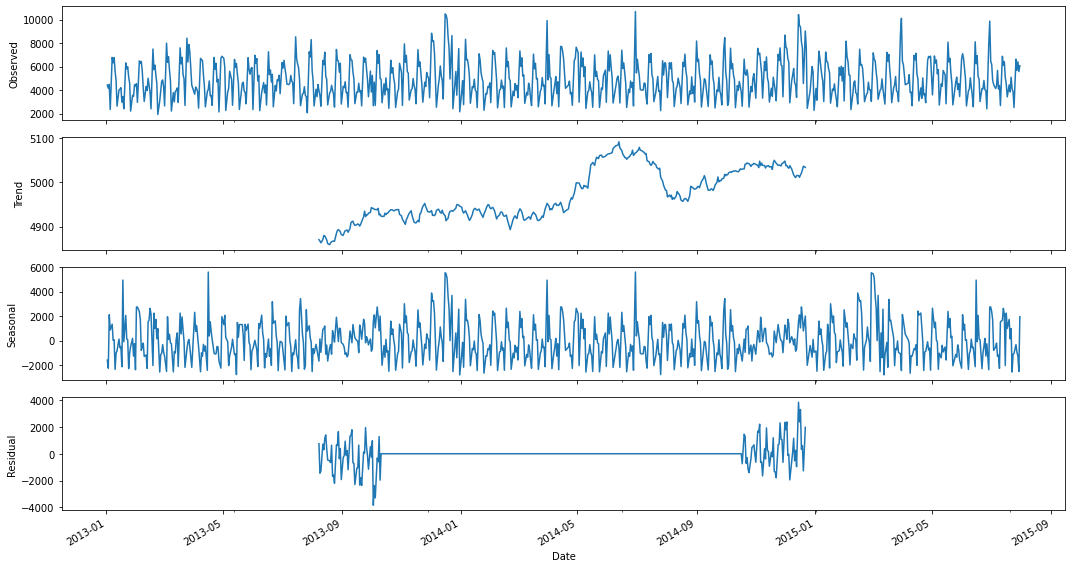

In [56]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize']=15,8
decomposition=sm.tsa.seasonal_decompose(sales_a,model='additive',freq=365)
fig=decomposition.plot()
plt.show()

**FOR STORE TYPE A**
THERE IS A TREND THAT IS THERE IS ALWAYS AN INCREASE IN SALES
WHILE THE SEASONALITY IS THERE IS ALWAYS AN INCREASE DURING DECEMEBER HOLIDAYS

**For store type b**

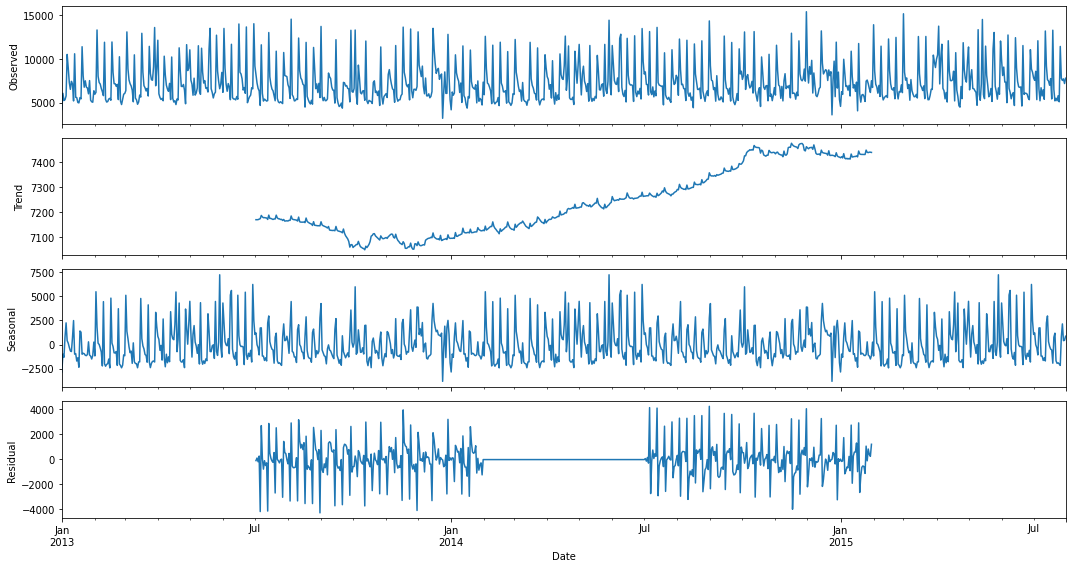

In [57]:
rcParams['figure.figsize']=15,8
decomposition=sm.tsa.seasonal_decompose(sales_b,model='additive',freq=365)
fig=decomposition.plot()
plt.show()

**For store type c**

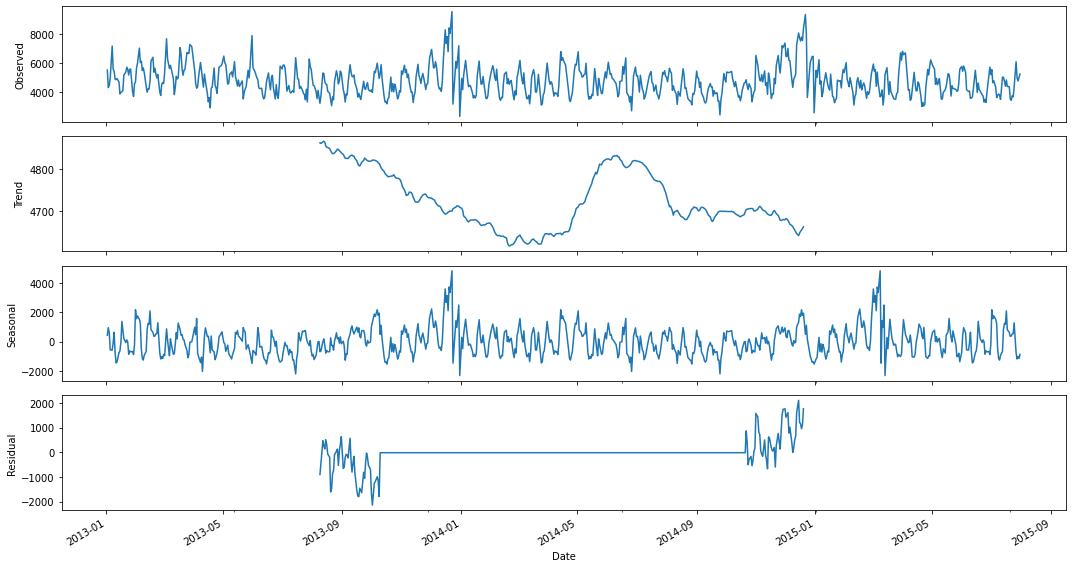

In [58]:
rcParams['figure.figsize']=15,8
decomposition=sm.tsa.seasonal_decompose(sales_c,model='additive',freq=365)
fig=decomposition.plot()
plt.show()

**Fore store type d**

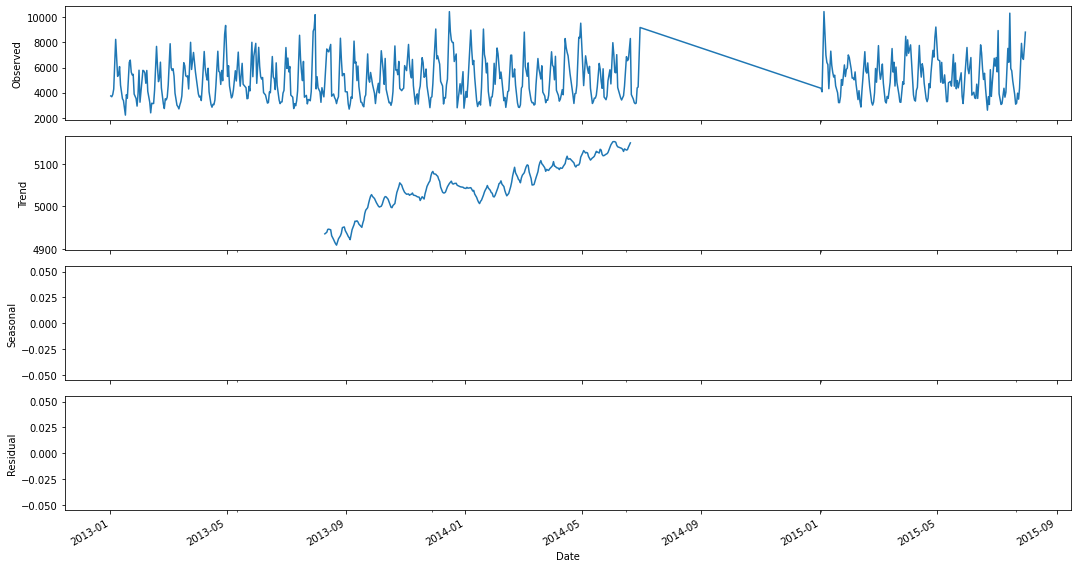

In [59]:
rcParams['figure.figsize']=15,8
decomposition=sm.tsa.seasonal_decompose(sales_d,model='additive',freq=365)
fig=decomposition.plot()
plt.show()

**FOR STORE TYPE D**
 THERE IS AN INCREASING TREND THROUGHOUT THE YEARS BUT THERE IS NO SEASONALITY MAYBE BECAUSE THE STORE WAS CLOSED AND NO DATA WAS AVAILABLE.

**NOW LETS CHECK FOR AUTOCORRELATION**

Autocorrelation is the degree of similarity between a given time series and a lagged version of itself over a period of time

It can be used to detect:
1. Non randomness in data.
2. To identify an appropriate time series model if data are not random.

1. **ACF(Auto Correlation Fuction)**: In moving average series of lag n, we will not get any correlation between x(t) and x(t-n-1). total correlation chart cuts off at nth lag.
2. **PACF(Partial Auto Correlation Fuction)**: If we exclude the effect of 1st lag AR(1) series. x(t-1),our 2nd lag (x(t-2)) will be independent of x(t). Hence, partial correlation function drop sharply after the first lag.

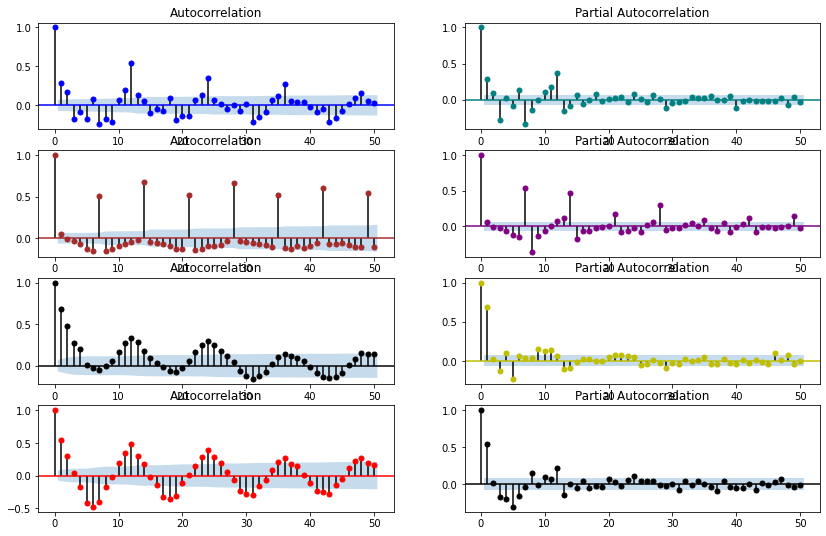

In [60]:
plt.figure(figsize = (14, 9))

# acf and pacf for A
plt.subplot(421)
plot_acf(sales_a, lags = 50, ax = plt.gca(), color = 'b')
plt.subplot(422) 
plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = 'teal')

# acf and pacf for B
plt.subplot(423); 
plot_acf(sales_b, lags = 50, ax = plt.gca(), color ='brown')
plt.subplot(424);
plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = 'purple')

# acf and pacf for C
plt.subplot(425);
plot_acf(sales_c, lags = 50, ax = plt.gca(), color = 'k')
plt.subplot(426);
plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = 'y')

# acf and pacf for D
plt.subplot(427);
plot_acf(sales_d, lags = 50, ax = plt.gca(), color = 'r')
plt.subplot(428);
plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = 'k')

plt.show()

We can see different correlation plots; each horizontal plot is for different store types from A to D.

We can infer that:
1. In both store type A and B there exists seasonality.
* In store type A we can see that there is a positive spike after every 11th observation i.e. at 12th position then 24th position and so on.
* In store type B we can see that there is a positive spike after every 6th observation i.e. there is a positive spike at every multiple of 7 for example at 7th observation at 14th observation and so on. 
2. In correlation plot of store type C and D there is a correlation with every adjacent observation.

**NEXT WE WILL BE USING FB PROPHET FOR TIME SERIES FORECASTING**

In [61]:
df.head(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day,weekofyear,SalesPerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263.0,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064.0,625,1,1,0,1,2015,7,31,31,9.702400


We have already removed the closed stores and those with zero sales

In [62]:
n=df[df.Store == 1].reset_index().loc[:, ['Date', 'Sales']]
n.head()

,Date,Sales
0,2015-07-31,5263.0
1,2015-07-30,5020.0
2,2015-07-29,4782.0
3,2015-07-28,5011.0
4,2015-07-27,6102.0


In [63]:
 n = n.sort_index(ascending = False)

# to datetime64
n['Date'] = pd.DatetimeIndex(n['Date'])
n.dtypes

Date     datetime64[ns]
Sales           float64
dtype: object

In [64]:
n.head()

,Date,Sales
780,2013-01-02,5530.0
779,2013-01-03,4327.0
778,2013-01-04,4486.0
777,2013-01-05,4997.0
776,2013-01-07,7176.0


In [65]:
# Format data for prophet model using ds and y
sales = n.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
780,2013-01-02,5530.0
779,2013-01-03,4327.0
778,2013-01-04,4486.0
777,2013-01-05,4997.0
776,2013-01-07,7176.0


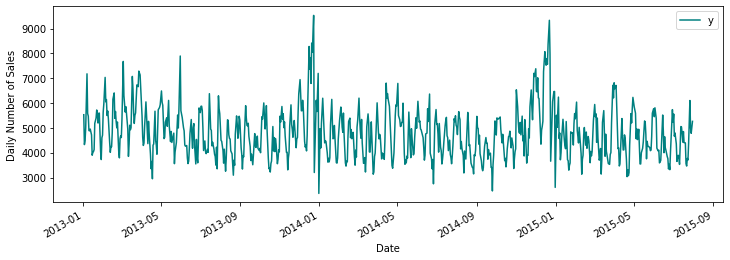

In [67]:
# plotting daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = 'teal')
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

In [ ]:
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

In [70]:
df=df.reset_index()
df.StateHoliday.value_counts()

0    843428
a       694
b       145
c        71
Name: StateHoliday, dtype: int64

There are 3 different holidays a, b and c
we will

In [83]:
state_hol = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_hol = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_hol)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_hol)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [84]:
holidays.holiday.value_counts()

school_holiday    163445
state_holiday        694
Name: holiday, dtype: int64

In [85]:
#using Prophet model
model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
model.fit(sales)

# dataframe that extends into future 6 weeks 
forecasted_dates = model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
forecasted_dates.tail(5)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


First week to forecast.


,ds
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [86]:
forecast = model.predict(forecasted_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
818,2015-09-07,4161.813517,2545.812784,5778.865556
819,2015-09-08,3664.142168,2080.888014,5194.990993
820,2015-09-09,3550.915165,1904.683958,5173.190956
821,2015-09-10,3462.435748,1771.258833,5162.521231
822,2015-09-11,3717.122489,2226.887852,5394.995728


In [87]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

In [88]:
fc.head(5)

,ds,yhat
0,2013-01-02,5480.034532
1,2013-01-03,5270.348125
2,2013-01-04,5408.981697
3,2013-01-05,5707.374245
4,2013-01-07,5629.708142


**We will further visualize the forecasting**

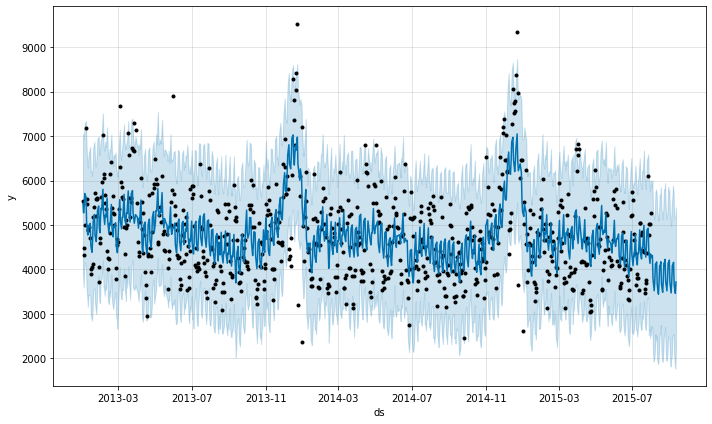

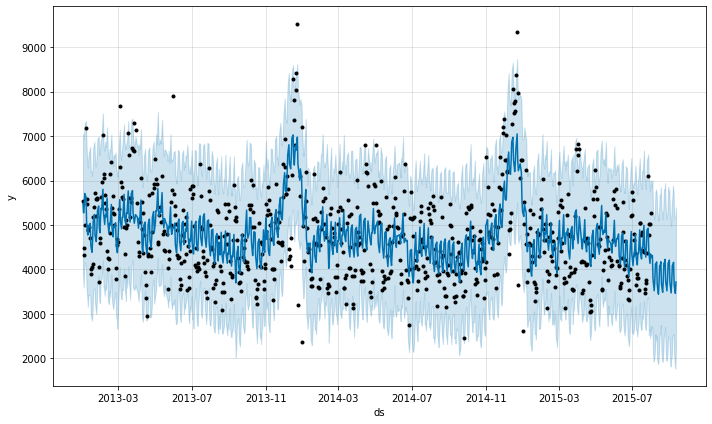

In [89]:
model.plot(forecast)

We can see that the black dots are the actual observed values, the blue lines are the forecasted values while the blue shaded regions is the uncertainity 

From our plot we can infer that majority of the times our model has predicted accurate values. And also our model was able to catch the trend and seasonality of our data.

Further fb prophet can help us visualize daily weekly monthly yearly sales.

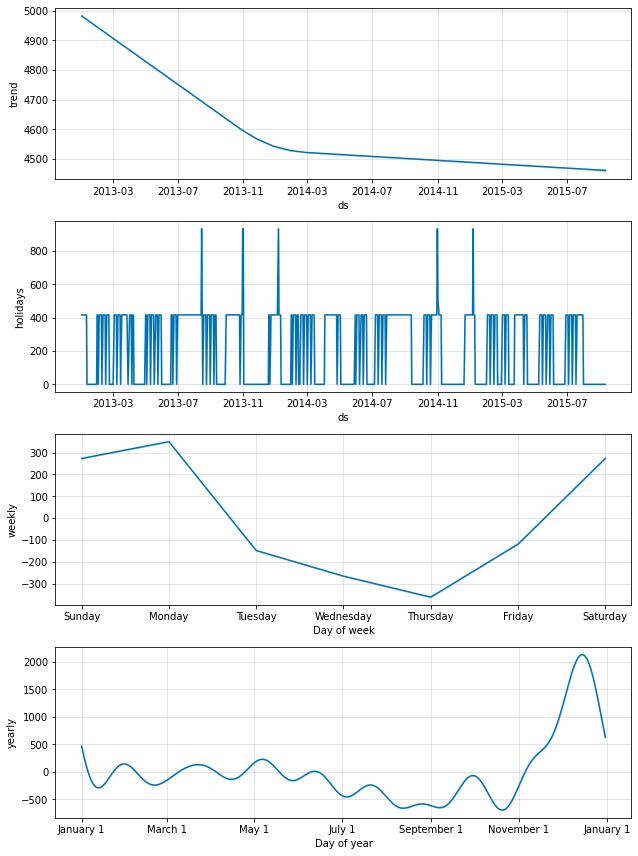

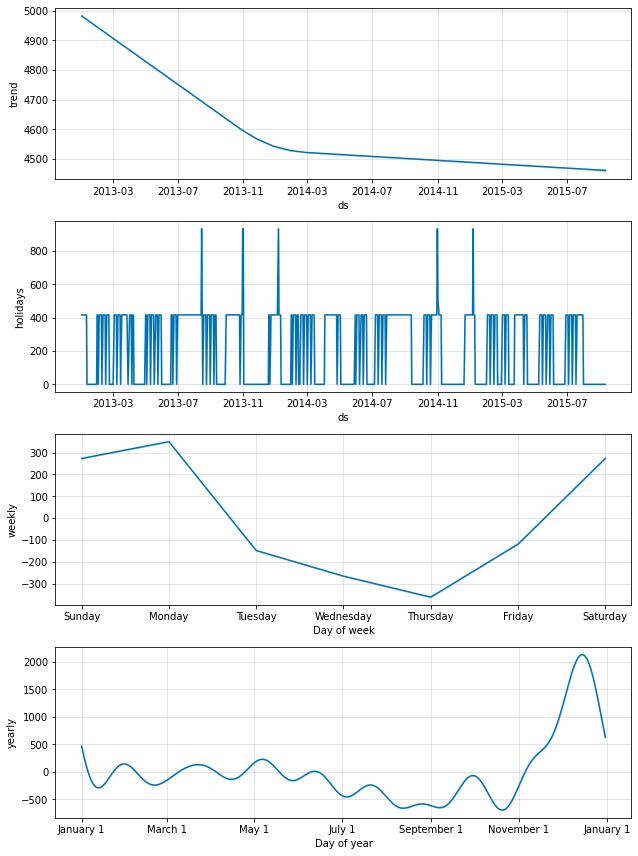

In [80]:
model.plot_components(forecast)

1. We can see that the sales of store number 1 is increasing in th month of December maybe during Christmas holidays.
2. While the sales is high mostlt in weekends and the highest on Mondays.

In [82]:
print("observed value",int(sales.y.sum()),";Forecasting values",int(forecast.yhat.sum()),";Forecasting lower bound",int(forecast.yhat_lower.sum()),"; Forecasting upper bound",int(forecast.yhat_upper.sum()))

observed value 3716854 ;Forecasting values 3878489 ;Forecasting lower bound 2544842 ; Forecasting upper bound 5215012


In [90]:
st1=df[df.Store == 1].reset_index().loc[:, ['Date', 'Sales']]
st2=df[df.Store==2].reset_index().loc[:,['Date','Sales']]


In [91]:
st1=st1.sort_index(ascending = False)
st2=st2.sort_index(ascending=False)
# to datetime64
st1['Date'] = pd.DatetimeIndex(st1['Date'])
st2['Date'] = pd.DatetimeIndex(st2['Date'])
st1.dtypes

Date     datetime64[ns]
Sales           float64
dtype: object

In [92]:
st1.head()

,Date,Sales
780,2013-01-02,5530.0
779,2013-01-03,4327.0
778,2013-01-04,4486.0
777,2013-01-05,4997.0
776,2013-01-07,7176.0


In [93]:
st2.head()

,Date,Sales
783,2013-01-02,4422.0
782,2013-01-03,4159.0
781,2013-01-04,4484.0
780,2013-01-05,2342.0
779,2013-01-07,6775.0


In [ ]:
sales = n.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Store 1 Sales')

<Figure size 1296x432 with 0 Axes>

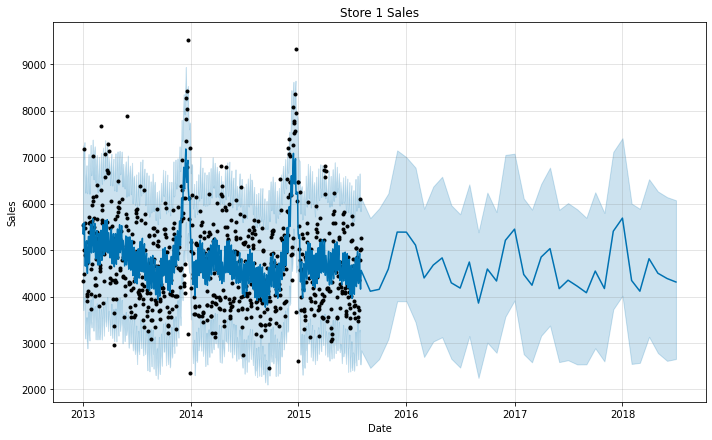

In [94]:
st1 = st1.rename(columns={'Date': 'ds', 'Sales': 'y'})
st1_model = Prophet(interval_width=0.95)
st1_model.fit(st1)
st2 = st2.rename(columns={'Date': 'ds', 'Sales': 'y'})
st2_model = Prophet(interval_width=0.95)
st2_model.fit(st2)
st1_forecast = st1_model.make_future_dataframe(periods=36, freq='MS')
st1_forecast = st1_model.predict(st1_forecast)
st2_forecast = st2_model.make_future_dataframe(periods=36, freq='MS')
st2_forecast = st2_model.predict(st2_forecast)
plt.figure(figsize=(18, 6))
st1_model.plot(st1_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Store 1 Sales')

Text(0.5, 1.0, 'Store 2 Sales')

<Figure size 1296x432 with 0 Axes>

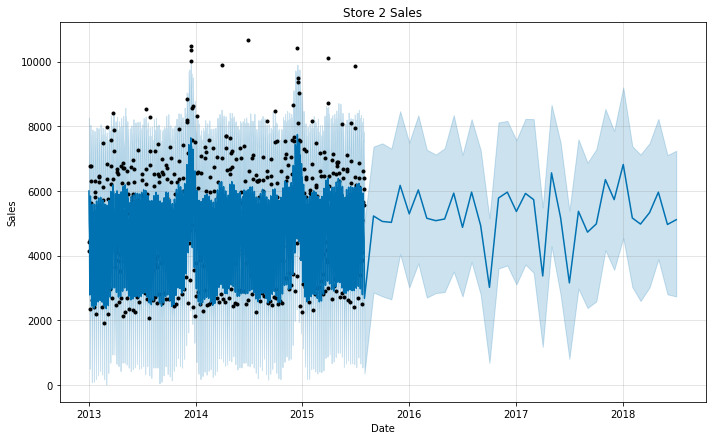

In [95]:
plt.figure(figsize=(18, 6))
st2_model.plot(st2_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Store 2 Sales')

In [96]:
st1_names = ['Store1_%s' % column for column in st1_forecast.columns]
st2_names = ['Store2_%s' % column for column in st2_forecast.columns]
merge_st1_forecast = st1_forecast.copy()
merge_st2_forecast = st2_forecast.copy()
merge_st1_forecast.columns = st1_names
merge_st2_forecast.columns = st2_names

In [99]:
forecast = pd.merge(merge_st1_forecast, merge_st2_forecast, how = 'inner', left_on = 'Store1_ds', right_on = 'Store2_ds')
forecast = forecast.rename(columns={'Store1_ds': 'Date'}).drop('Store2_ds', axis=1)
forecast.head()

,Date,Store1_trend,Store1_yhat_lower,Store1_yhat_upper,Store1_trend_lower,Store1_trend_upper,Store1_additive_terms,Store1_additive_terms_lower,Store1_additive_terms_upper,Store1_weekly,Store1_weekly_lower,Store1_weekly_upper,Store1_yearly,Store1_yearly_lower,Store1_yearly_upper,Store1_multiplicative_terms,Store1_multiplicative_terms_lower,Store1_multiplicative_terms_upper,Store1_yhat,Store2_trend,Store2_yhat_lower,Store2_yhat_upper,Store2_trend_lower,Store2_trend_upper,Store2_additive_terms,Store2_additive_terms_lower,Store2_additive_terms_upper,Store2_weekly,Store2_weekly_lower,Store2_weekly_upper,Store2_yearly,Store2_yearly_lower,Store2_yearly_upper,Store2_multiplicative_terms,Store2_multiplicative_terms_lower,Store2_multiplicative_terms_upper,Store2_yhat
0,2013-01-02,5233.606850,3896.926325,7249.991968,5233.606850,5233.606850,326.914183,326.914183,326.914183,-219.648835,-219.648835,-219.648835,546.563018,546.563018,546.563018,0.0,0.0,0.0,5560.521033,4832.302354,3717.536908,8270.729984,4832.302354,4832.302354,1166.878456,1166.878456,1166.878456,908.964183,908.964183,908.964183,257.914272,257.914272,257.914272,0.0,0.0,0.0,5999.180809
1,2013-01-03,5232.198256,3707.308450,6952.707000,5232.198256,5232.198256,108.923125,108.923125,108.923125,-309.090443,-309.090443,-309.090443,418.013568,418.013568,418.013568,0.0,0.0,0.0,5341.121381,4832.571119,2734.755212,7299.120617,4832.571119,4832.571119,226.207806,226.207806,226.207806,54.694809,54.694809,54.694809,171.512997,171.512997,171.512997,0.0,0.0,0.0,5058.778925
2,2013-01-04,5230.789662,3819.280530,7126.129210,5230.789662,5230.789662,240.493562,240.493562,240.493562,-54.528862,-54.528862,-54.528862,295.022424,295.022424,295.022424,0.0,0.0,0.0,5471.283224,4832.839884,2528.119916,6999.302530,4832.839884,4832.839884,-161.410119,-161.410119,-161.410119,-251.792657,-251.792657,-251.792657,90.382538,90.382538,90.382538,0.0,0.0,0.0,4671.429765
3,2013-01-05,5229.381068,3880.863619,7169.309544,5229.381068,5229.381068,329.719248,329.719248,329.719248,150.705304,150.705304,150.705304,179.013944,179.013944,179.013944,0.0,0.0,0.0,5559.100316,4833.108648,504.432720,5157.540923,4833.108648,4833.108648,-2049.161493,-2049.161493,-2049.161493,-2064.212490,-2064.212490,-2064.212490,15.050996,15.050996,15.050996,0.0,0.0,0.0,2783.947155
4,2013-01-07,5226.563879,3979.092891,7321.700687,5226.563879,5226.563879,360.760881,360.760881,360.760881,387.931179,387.931179,387.931179,-27.170299,-27.170299,-27.170299,0.0,0.0,0.0,5587.324760,4833.646178,3603.752121,8046.104728,4833.646178,4833.646178,1008.985763,1008.985763,1008.985763,1125.705469,1125.705469,1125.705469,-116.719706,-116.719706,-116.719706,0.0,0.0,0.0,5842.631941


Text(0.5, 1.0, 'Store 1 vs. Store 2 Sales Trend')

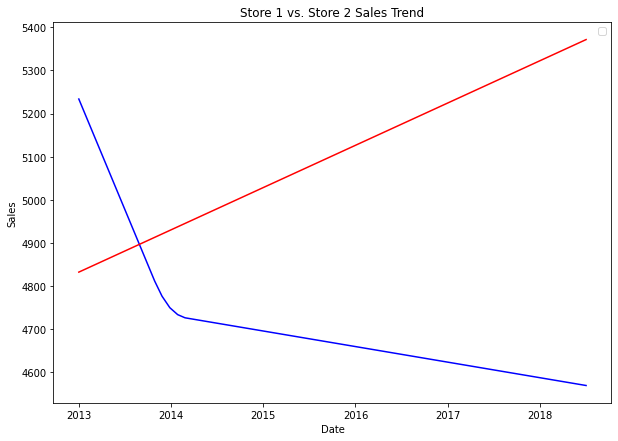

In [100]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['Store1_trend'], 'b-')
plt.plot(forecast['Date'], forecast['Store2_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Store 1 vs. Store 2 Sales Trend')

Text(0.5, 1.0, 'Store 1 vs. Store 2 Estimate')

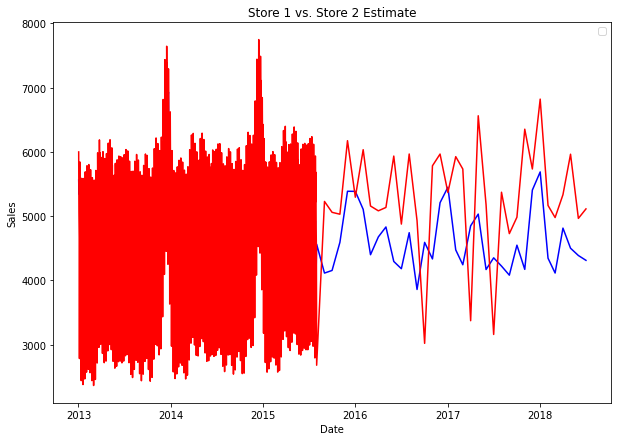

In [101]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['Store1_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['Store2_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Store 1 vs. Store 2 Estimate')

**We can see that sales of store number 2 is very high compared to store number 1. And the sales of store 1 is constantly decreasing while of store number 2 is increasing.**